# 구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 필요한 모듈 불러오기

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 데이터 파일 설명

* `air_visit_data`: air restaurants의 과거 방문 data, main_training data set이다.

* `air_reserve_csv` / `hpg_reserve.csv`: air & hpg 예약 시스템

* `air_store_info` / `hpg_store_info`: air & hpg의 세부정보

* `store_id_relation`: air & hpg id

* `date_info` : 일본 공휴일 정보

* `sample_submission` : test 데이터로 사용한다.

# 데이터 불러오기

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/해커톤'

air_reserve = pd.read_csv(data_dir + '/air_reserve.csv')
air_store_info = pd.read_csv(data_dir + '/air_store_info.csv')
air_visit_data = pd.read_csv(data_dir + '/air_visit_data.csv')
date_info = pd.read_csv(data_dir + '/date_info.csv')
hpg_reserve = pd.read_csv(data_dir + '/hpg_reserve.csv')
hpg_store_info = pd.read_csv(data_dir + '/hpg_store_info.csv')
store_id_relation = pd.read_csv(data_dir + '/store_id_relation.csv')
sample_submission = pd.read_csv(data_dir + '/sample_submission.csv')

# 데이터 확인

* `isnull().sum()`을 통해 결측치와 변수를 동시에 확인한다.

In [ ]:
print("[Air reserve data]:", air_reserve.isnull().sum(), \
      "[Air store data]:", air_store_info.isnull().sum(), \
      "[Air visit data]:", air_visit_data.isnull().sum(), \
      "[Date info data]:", date_info.isnull().sum(), \
      "[Hpg_reserve data]:", hpg_reserve.isnull().sum(), \
      "[Hpg_store_info]: ", hpg_store_info.isnull().sum(), \
      "[Store id relation data]:", store_id_relation.isnull().sum(),\
      "[Submission data]:", sample_submission.isnull().sum(), sep='\n\n')

[Air reserve data]:

air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

[Air store data]:

air_store_id      0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
dtype: int64

[Air visit data]:

air_store_id    0
visit_date      0
visitors        0
dtype: int64

[Date info data]:

calendar_date    0
day_of_week      0
holiday_flg      0
dtype: int64

[Hpg_reserve data]:

hpg_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

[Hpg_store_info]: 

hpg_store_id      0
hpg_genre_name    0
hpg_area_name     0
latitude          0
longitude         0
dtype: int64

[Store id relation data]:

air_store_id    0
hpg_store_id    0
dtype: int64

[Submission data]:

id          0
visitors    0
dtype: int64


In [ ]:
print('Training data shape:', air_visit_data.shape)
print('Unique store id in training data:', len(air_visit_data['air_store_id'].unique()))
print('Id data shape:', store_id_relation.shape)
print('Air store data:', air_store_info.shape, '/ Unique:', air_store_info['air_store_id'].unique().shape)
print('Hpg store data:', hpg_store_info.shape, '/ Unique:', hpg_store_info['hpg_store_id'].unique().shape)
print('Air reserve data:', air_reserve.shape, '/ Unique:', air_reserve['air_store_id'].unique().shape)
print('Hpg reserve data:', hpg_reserve.shape, '/ Unique:', hpg_reserve['hpg_store_id'].unique().shape)

Training data shape: (252108, 3)
Unique store id in training data: 829
Id data shape: (150, 2)
Air store data: (829, 5) / Unique: (829,)
Hpg store data: (4690, 5) / Unique: (4690,)
Air reserve data: (92378, 4) / Unique: (314,)
Hpg reserve data: (2000320, 4) / Unique: (13325,)


---

# 데이터 병합

## 예약자 수 확인하기 위한 작업

* 예약자 수가 담겨져 있는 데이터와, store의 정보가 담겨져 있는 데이터를 고유 `id`를 기준으로 `inner join` 했다.

In [ ]:
air = pd.merge(air_reserve, air_store_info, on='air_store_id', how='inner')
display(air.head(3), air.shape, air['air_store_id'].unique().shape)

hpg = pd.merge(hpg_reserve, hpg_store_info, on='hpg_store_id', how='inner')
display(hpg.head(3), hpg.shape, hpg['hpg_store_id'].unique().shape)

air_store_id       visit_datetime  ...   latitude   longitude
0  air_877f79706adbfb06  2016-01-01 19:00:00  ...  35.658068  139.751599
1  air_877f79706adbfb06  2016-01-01 20:00:00  ...  35.658068  139.751599
2  air_877f79706adbfb06  2016-01-02 18:00:00  ...  35.658068  139.751599

[3 rows x 8 columns]

(92378, 8)

(314,)

hpg_store_id       visit_datetime  ...   latitude   longitude
0  hpg_dac72789163a3f47  2016-01-01 13:00:00  ...  34.692109  135.191698
1  hpg_dac72789163a3f47  2016-01-02 12:00:00  ...  34.692109  135.191698
2  hpg_dac72789163a3f47  2016-01-03 19:00:00  ...  34.692109  135.191698

[3 rows x 8 columns]

(871308, 8)

(4690,)

---

In [ ]:
store_id_relation.head()

air_store_id          hpg_store_id
0  air_63b13c56b7201bd9  hpg_4bc649e72e2a239a
1  air_a24bf50c3e90d583  hpg_c34b496d0305a809
2  air_c7f78b4f3cba33ff  hpg_cd8ae0d9bbd58ff9
3  air_947eb2cae4f3e8f2  hpg_de24ea49dc25d6b8
4  air_965b2e0cf4119003  hpg_653238a84804d8e7

* `air_store_id`와 `hpg_store_id`가 상호 배타적인 예약을 하고 있다고 가정
* `index`가 같은 `id`끼리 연관이 있다고 가정하고, `hpg`데이터에 `air_store_id`를 가져오는 과정을 진행한다.

In [ ]:
hpg = pd.merge(store_id_relation, hpg, on='hpg_store_id', how='inner')
display(hpg.head(3), hpg.shape)

air_store_id          hpg_store_id  ...   latitude   longitude
0  air_a24bf50c3e90d583  hpg_c34b496d0305a809  ...  34.721644  137.738944
1  air_a24bf50c3e90d583  hpg_c34b496d0305a809  ...  34.721644  137.738944
2  air_a24bf50c3e90d583  hpg_c34b496d0305a809  ...  34.721644  137.738944

[3 rows x 9 columns]

(13528, 9)

* 우리가 가지고 있는 `submission` 데이터는 `air_store_id`를 기준으로 방문자를 예측하고 있으므로<br> `hpg_store_id`를 `drop`한다.

In [ ]:
hpg = hpg.drop(['hpg_store_id'],axis =1)

In [ ]:
display(hpg.head(3), hpg.shape)

air_store_id       visit_datetime  ...   latitude   longitude
0  air_a24bf50c3e90d583  2016-01-06 19:00:00  ...  34.721644  137.738944
1  air_a24bf50c3e90d583  2016-01-07 21:00:00  ...  34.721644  137.738944
2  air_a24bf50c3e90d583  2016-01-08 19:00:00  ...  34.721644  137.738944

[3 rows x 8 columns]

(13528, 8)

* `hpg_store_id`를 `drop`하였고 <br>
`air`를 기준으로 하기 위해 `rename`을 통해 변수명을 바꿔준다.

* 변수명을 바꿔주는 이유는 이후 `air`데이터와 병합하기 위함이다.

In [ ]:
hpg.rename(columns={'hpg_genre_name': 'air_genre_name', \
                    'hpg_area_name': 'air_area_name'}, inplace=True)
#renaming column names to match up with the air_combine dataset
display(hpg.head(3), hpg.shape)

air_store_id       visit_datetime  ...   latitude   longitude
0  air_a24bf50c3e90d583  2016-01-06 19:00:00  ...  34.721644  137.738944
1  air_a24bf50c3e90d583  2016-01-07 21:00:00  ...  34.721644  137.738944
2  air_a24bf50c3e90d583  2016-01-08 19:00:00  ...  34.721644  137.738944

[3 rows x 8 columns]

(13528, 8)

In [ ]:
print(air.shape)
print(hpg.shape)

(92378, 8)
(13528, 8)


---

* 지금까지 만든 `air`데이터와 `hpg`데이터를 병합한다.

In [ ]:
air = pd.concat([air, hpg], axis=0) 

In [ ]:
display(air.head(), air.shape)

air_store_id       visit_datetime  ...   latitude   longitude
0  air_877f79706adbfb06  2016-01-01 19:00:00  ...  35.658068  139.751599
1  air_877f79706adbfb06  2016-01-01 20:00:00  ...  35.658068  139.751599
2  air_877f79706adbfb06  2016-01-02 18:00:00  ...  35.658068  139.751599
3  air_877f79706adbfb06  2016-01-02 21:00:00  ...  35.658068  139.751599
4  air_877f79706adbfb06  2016-01-08 21:00:00  ...  35.658068  139.751599

[5 rows x 8 columns]

(105906, 8)

> 단계별로 생각해보자❗

1. `air_reverse`, `air_store_info`를 `air_store_id` 기준으로 병합함<br>
`hpg_reverse`, `hpg_store_info`도 마찬가지이다.

2. `store_id_relation`과 새롭게 만들어진 `hpg`데이터 병합<br>
`test data`가 `air_store_id`기준으로 만들어졌기 때문에 `hpg_store_id`에 해당되는 `air_store_id`를 가져오는 과정

3. `hpg_stroe_id`를 `drop`하고 `air`를 기준으로 `rename`하는 과정

4. `concat`을 활용해 만들어진 데이터를 병합한다

---

# 휴일 데이터 활용하기

In [ ]:
date_info.head()

calendar_date day_of_week  holiday_flg
0    2016-01-01      Friday            1
1    2016-01-02    Saturday            1
2    2016-01-03      Sunday            1
3    2016-01-04      Monday            0
4    2016-01-05     Tuesday            0

In [ ]:
air['visit_date'] = pd.to_datetime(air['visit_datetime'])
air['visit_date'] = air['visit_date'].dt.date

In [ ]:
air.head(1)

air_store_id       visit_datetime  ...   longitude  visit_date
0  air_877f79706adbfb06  2016-01-01 19:00:00  ...  139.751599  2016-01-01

[1 rows x 9 columns]

In [ ]:
date_info.rename(columns={'calendar_date': 'visit_date'}, inplace=True)

* 휴일 정보가 담겨있는 데이터와 `air` 데이터를 합친 과정이다.

* `date_info` 데이터는 `visit_date`가 **객체**이므로 `date parsing` 작업을 통해 유형을 변경한 후 합쳐주었다.

In [ ]:
date_info['visit_date'] = pd.to_datetime(date_info['visit_date'])
date_info['visit_date'] = date_info['visit_date'].dt.date

In [ ]:
air = pd.merge(air, date_info)

In [ ]:
display(air.head(3), air.shape)

air_store_id       visit_datetime  ... day_of_week  holiday_flg
0  air_877f79706adbfb06  2016-01-01 19:00:00  ...      Friday            1
1  air_877f79706adbfb06  2016-01-01 20:00:00  ...      Friday            1
2  air_db4b38ebe7a7ceff  2016-01-01 19:00:00  ...      Friday            1

[3 rows x 11 columns]

(105906, 11)

* 결측치가 없이 깔끔하게 합쳐진 것을 확인할 수 있었다.

In [ ]:
air.isnull().sum()

air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
air_genre_name      0
air_area_name       0
latitude            0
longitude           0
visit_date          0
day_of_week         0
holiday_flg         0
dtype: int64

> **진행 상황**<br>
결국에는 예약자 데이터, 가게 정보가 담긴 데이터, 휴일 데이터를 합치는 과정까지 진행하게 되었다.

---

# 결측치 확인 및 유형 확인

In [ ]:
air.isnull().sum()

air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
air_genre_name      0
air_area_name       0
latitude            0
longitude           0
visit_date          0
day_of_week         0
holiday_flg         0
dtype: int64

In [ ]:
air.isnull().any()

air_store_id        False
visit_datetime      False
reserve_datetime    False
reserve_visitors    False
air_genre_name      False
air_area_name       False
latitude            False
longitude           False
visit_date          False
day_of_week         False
holiday_flg         False
dtype: bool

* 데이터를 각 값에 맞는 유형으로 변경하였다.

In [ ]:
air['holiday_flg'] = air['holiday_flg'].astype('int8')
air['day_of_week'] = air['day_of_week'].astype('category')
air['air_genre_name'] = air['air_genre_name'].astype('category')
air['air_area_name'] = air['air_area_name'].astype('category')
air['air_store_id'] = air['air_store_id'].astype('category')
air['reserve_visitors'] = air['reserve_visitors'].astype('int8')
air['visit_datetime'] = pd.to_datetime(air['visit_datetime'])
air['reserve_datetime'] = pd.to_datetime(air['reserve_datetime'])

In [ ]:
air.dtypes

air_store_id              category
visit_datetime      datetime64[ns]
reserve_datetime    datetime64[ns]
reserve_visitors              int8
air_genre_name            category
air_area_name             category
latitude                   float64
longitude                  float64
visit_date                  object
day_of_week               category
holiday_flg                   int8
dtype: object

In [ ]:
air.head(3)

air_store_id      visit_datetime  ... day_of_week  holiday_flg
0  air_877f79706adbfb06 2016-01-01 19:00:00  ...      Friday            1
1  air_877f79706adbfb06 2016-01-01 20:00:00  ...      Friday            1
2  air_db4b38ebe7a7ceff 2016-01-01 19:00:00  ...      Friday            1

[3 rows x 11 columns]

---

* 다음은 시각화를 위해 날짜를 파싱한 것을 이용하는 과정이다.

* 일, 월, 년도, 요일 등등의 시간을 파싱하는 과정.

In [ ]:
air['day'] = air['visit_datetime'].dt.day
air['dow'] = air['visit_datetime'].dt.weekday
air['dow_name'] = air['visit_datetime'].dt.day_name()
air['year'] = air['visit_datetime'].dt.year
air['month'] = air['visit_datetime'].dt.month
air['week'] = air['visit_datetime'].dt.week
air['quarter'] = air['visit_datetime'].dt.quarter
air['visit_date'] = air['visit_datetime'].dt.date
air['hour'] = air['visit_datetime'].dt.hour

In [ ]:
air.head(3)

air_store_id      visit_datetime  ... quarter  hour
0  air_877f79706adbfb06 2016-01-01 19:00:00  ...       1    19
1  air_877f79706adbfb06 2016-01-01 20:00:00  ...       1    20
2  air_db4b38ebe7a7ceff 2016-01-01 19:00:00  ...       1    19

[3 rows x 19 columns]

* 일본의 행정구역으로 나누는 과정을 진행하였다.

* 좀 더 세밀하게 보기 위함이다.

In [ ]:
area_split = air["air_area_name"].str.split()
air['todobuken'] = area_split.str.get(0)
air['city'] = area_split.str.get(1)

display(air.head(3), air.shape)

air_store_id      visit_datetime  ... todobuken       city
0  air_877f79706adbfb06 2016-01-01 19:00:00  ...  Tōkyō-to  Minato-ku
1  air_877f79706adbfb06 2016-01-01 20:00:00  ...  Tōkyō-to  Minato-ku
2  air_db4b38ebe7a7ceff 2016-01-01 19:00:00  ...  Ōsaka-fu  Ōsaka-shi

[3 rows x 21 columns]

(105906, 21)

# 지금까지 병합한 데이터 시각화

* 지금까지 합친 데이터를 통해 **년도별, 월별, 일별, 시간별**로 예약자가 어느정도 있었는지 알아보는 과정이다.

* 시각화를 통해 데이터를 보면 한 눈에 알아보기 쉽다.

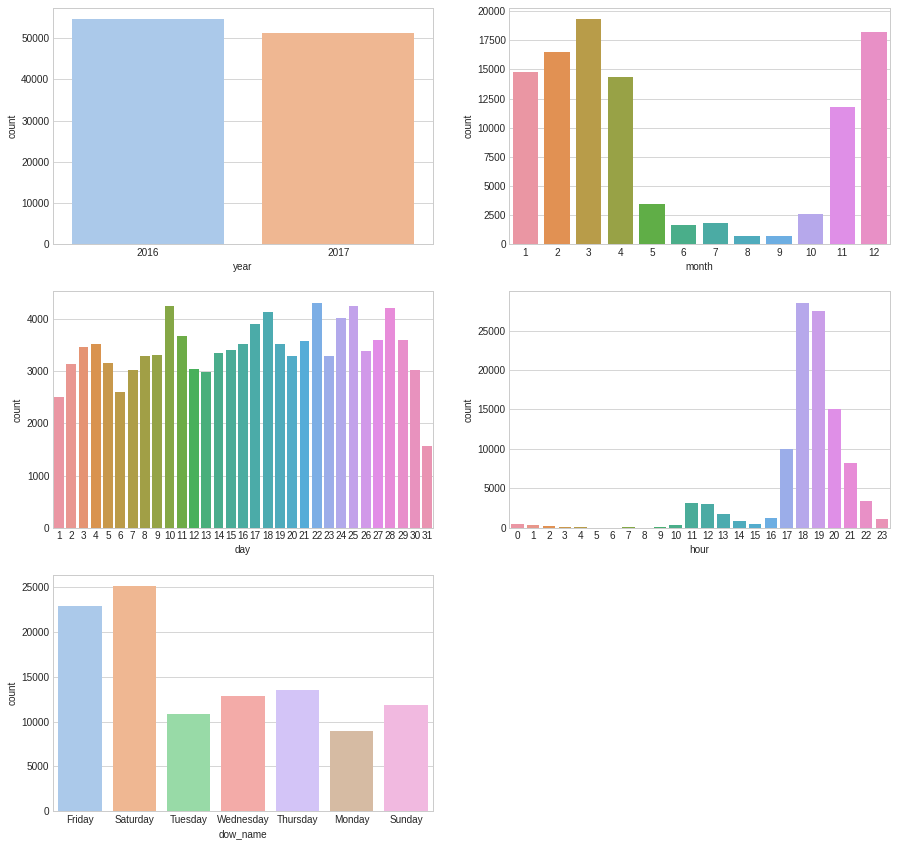

In [ ]:
sns.set_palette('pastel')

plt.figure(figsize=(15, 20))

plt.subplot(421)
sns.countplot(air['year'])

plt.subplot(422)
sns.countplot(air['month'])

plt.subplot(423)
sns.countplot(air['day'])

plt.subplot(424)
sns.countplot(air['hour'])

plt.subplot(425)
sns.countplot(air['dow_name'])

> **시각화 된 데이터 해석**

1. 2017년의 날짜 길이가 2016년보다 짧음에도 불구하고, 예약자 수의 큰 차이는 없었다. <br>
2017년 데이터도 2017-12-31까지 존재했다면 2016년 예약자 수 보다 더 많을 것으로 예상한다.

2. 예약자는 보통 1월 2월 3월, 11월 12월에 예약을 많이 하는 것으로 보인다.<br> 날씨가 무더우면 예약자수가 현저하게 줄어드는 모습을 확인할 수 있다.

3. 일별로 시각화한 모습을 보게되면, 월초, 월말에는 예약한 사람이 다른 날보다 비교적 적다.<br> 31일이 작은 이유는 매달에 31일이 존재하지 않기 때문이다.

4. 시간대별로 시각화한 모습에는 17시 이후부터 서서히 증가하다가 19시까지 최대치를 보여준다.<br> 퇴근시간에 사람들이 많이 예약하고 방문하는 모습을 살펴볼 수 있었다.

5. 금요일, 토요일에 예약한 방문자 수가 제일 많았고 월요일에 제일 적은 모습을 보인다.<br>




---

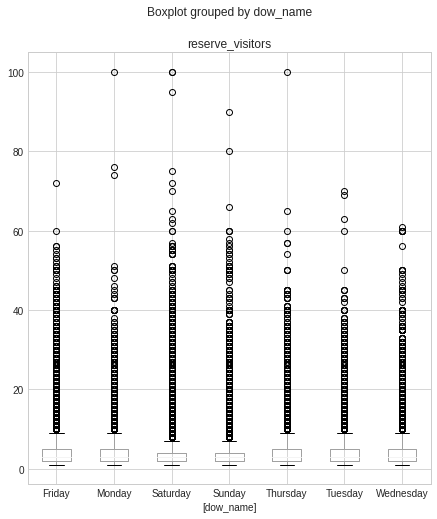

In [ ]:
air[['reserve_visitors', 'dow_name']].boxplot(by='dow_name')

* Boxplot으로 보기에도 월요일이 현저하게 적음을 알 수 있다. <br>가끔 100정도의 예약자 수가 보이는데, 가족 단위의 회식이나 회사 회식이 있는 경우 높은 값을 보이는 것으로 예상한다.
---

Text(0.5, 1.0, 'Visitor and Reservations')

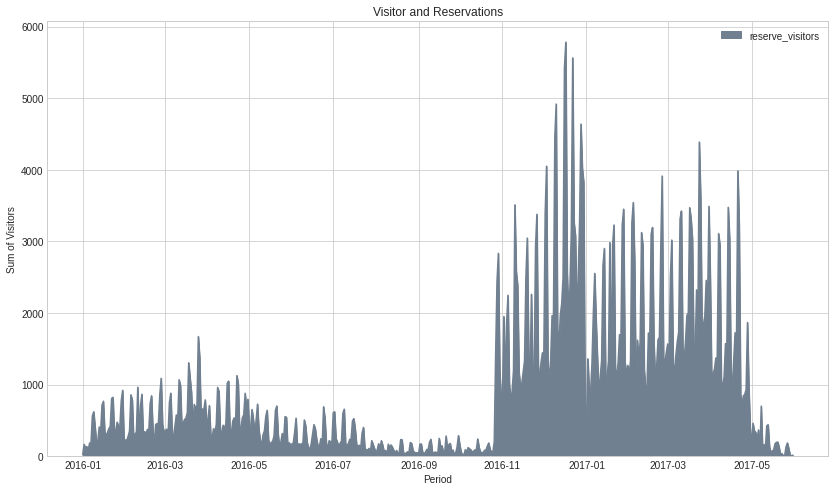

In [ ]:
import matplotlib.pyplot as plt

f,ax = plt.subplots(1,1,figsize=(14,8))
plt1 = air.groupby(['visit_date'], as_index=False).agg({'reserve_visitors': np.sum})
plt1 = plt1.set_index('visit_date')
plt1.plot(color='slategrey', kind='area', ax=ax)

plt.xlabel('Period')
plt.ylabel("Sum of Visitors")
plt.title("Visitor and Reservations")

> 시각화 된 데이터 해석

* 일단 2016년 air 시스템을 통한 예약 건수는 현저하게 적었다. <br>
2016년 말에는 예약 횟수가 거의 0에 가까울 정도로 적었다.<br> 2017년에는 방문자 수가 초강세를 보였다.

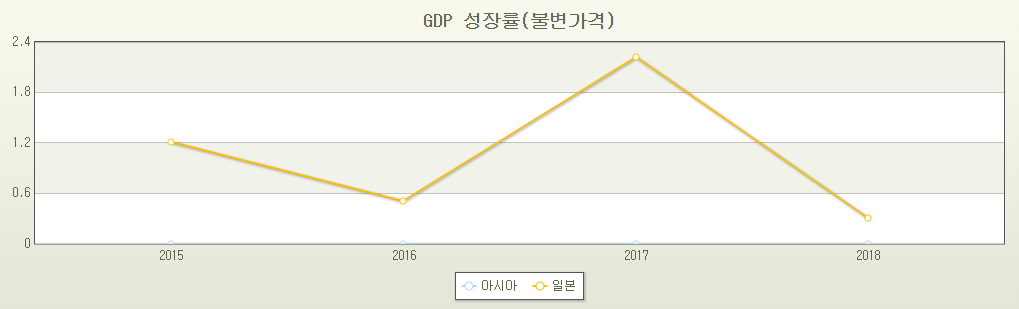

* 다른 요인과 관련이 있을 것 같아 일본의 **GDP 성장률** 그래프를 가져왔다.<br>\
 **GDP 성장률**: 일정 기간 동안 한 나라의 경제 성장을 나타내는 지표<BR>
[자료 출처 - 국가통계포탈(kosis)](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAA905&vw_cd=&list_id=&scrId=&seqNo=&lang_mode=ko&obj_var_id=&itm_id=&conn_path=E1&docId=0079431922&markType=S&itmNm=%EC%9D%BC%EB%B3%B8)<br>
일본의 경제성장률은 2016년에 저조하다가 2017년에 급등하였고, 2018년이 되는 기점 쯤에 다시 하락한 모습을 보여줬다. <br>
직접적으로 관련이 있다고 확실하지는 못하겠지만, 그래프가 위와 같이 그려진 이유에 대해 어느정도 설명할 수 있다고 생각한다.

---

* 다음은 가게 종류별 예약한 횟수를 시각화 한 과정이다.

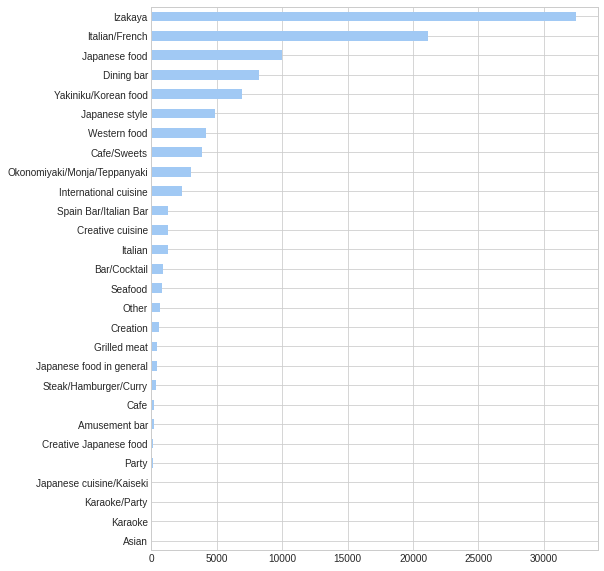

air_genre_name
Izakaya                         32489
Italian/French                  21106
Japanese food                   10021
Dining bar                       8243
Yakiniku/Korean food             6946
Japanese style                   4878
Western food                     4151
Cafe/Sweets                      3862
Okonomiyaki/Monja/Teppanyaki     3052
International cuisine            2347
Spain Bar/Italian Bar            1291
Creative cuisine                 1270
Italian                          1237
Bar/Cocktail                      910
Seafood                           826
Other                             679
Creation                          618
Grilled meat                      411
Japanese food in general          408
Steak/Hamburger/Curry             344
Cafe                              213
Amusement bar                     168
Creative Japanese food            151
Party                              90
Japanese cuisine/Kaiseki           85
Karaoke/Party                      

In [ ]:
air.air_genre_name.value_counts().sort_values().plot(kind='barh')
fig = plt.gcf()
fig.set_size_inches(8, 10)
fig.patch.set_facecolor('white')
plt.show()
print(air['air_store_id'].groupby(air['air_genre_name']).count().sort_values(ascending=False))

---

* 행정구역별 인기 장소 시각화

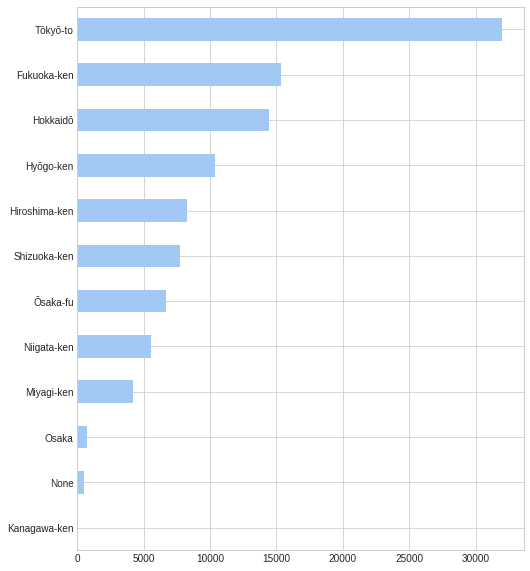

todobuken
Tōkyō-to         32012
Fukuoka-ken      15362
Hokkaidō         14453
Hyōgo-ken        10343
Hiroshima-ken     8282
Shizuoka-ken      7723
Ōsaka-fu          6698
Niigata-ken       5537
Miyagi-ken        4202
Osaka              713
None               546
Kanagawa-ken        35
Name: air_store_id, dtype: int64


In [ ]:
air.todobuken.value_counts().sort_values().plot(kind='barh')
fig=plt.gcf()
fig.set_size_inches(8, 10)
fig.patch.set_facecolor('white')
plt.show()
print(air['air_store_id'].groupby(air['todobuken']).count().sort_values(ascending=False))

* 확실히 수도인 도쿄가 가장 방문자가 많았다.

* 그 다음은 후쿠오카, 훗카이도 순이다.

* 오사카도 인기가 많을 줄 알았는데, 시각화를 한 결과 하위권에 위치되어있었다.

---

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 12 Text major ticklabel objects>)

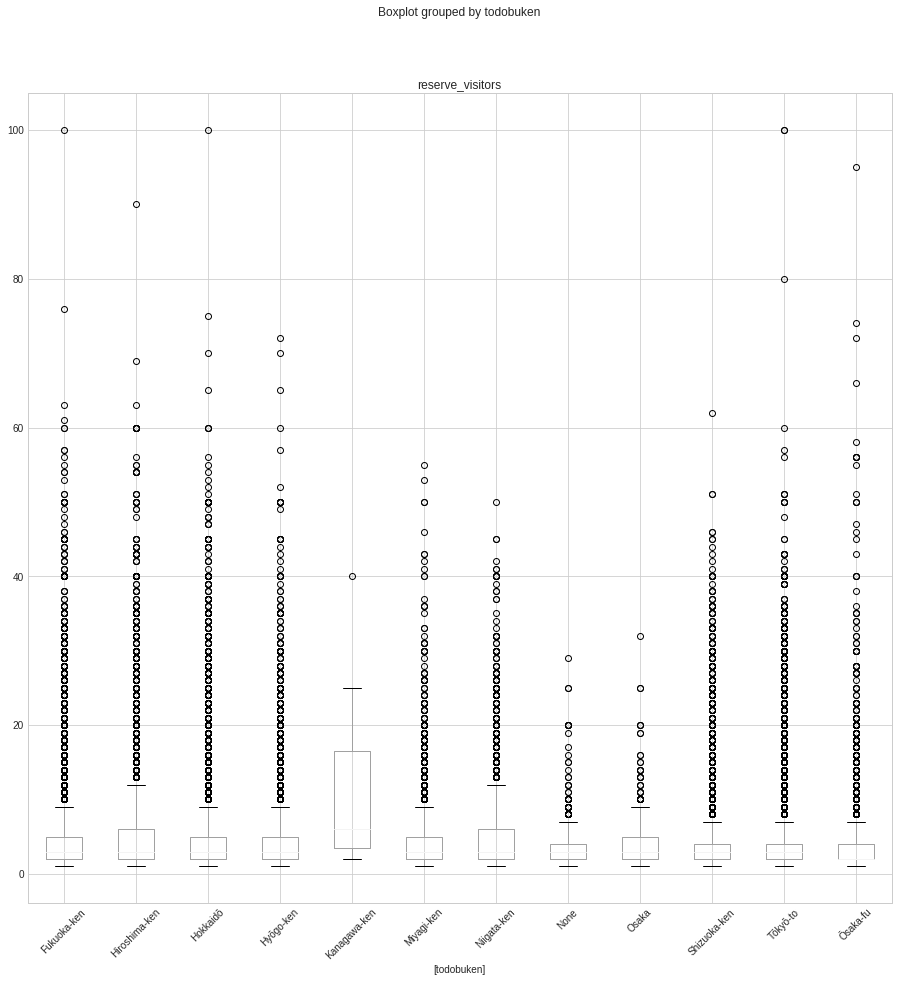

In [ ]:
plt.rcParams['figure.figsize'] = (15, 15)
air[['todobuken', 'reserve_visitors']].boxplot(by='todobuken')
plt.xticks(rotation=45)

---

In [ ]:
plt.figure(figsize=(30,10))
boxplot=air[['air_genre_name', 'reserve_visitors']].boxplot(by = 'air_genre_name', vert=0)
plt.show()

<Figure size 2160x720 with 0 Axes>

## 데이터 지도 시각화

[참고했던 커널](https://www.kaggle.com/faizalabdkadir/recruit-visual-eda-itadakimasu)

In [ ]:
import folium
from folium import plugins

In [ ]:
location = air.groupby(['latitude', 'longitude']).size().reset_index()
locationheat = location[['latitude', 'longitude']]
locationheat = locationheat.values.tolist()

map1 = folium.Map(location=[39, 139],
                  tiles="Stamen Watercolor",
                  zoom_start=5)

heatmap = plugins.HeatMap(locationheat).add_to(map1)
map1

In [ ]:
location =air.groupby(['air_store_id','air_genre_name'])['latitude','longitude'].mean().dropna(axis=0).reset_index(drop=False)
locationlist = location[['latitude', 'longitude']]
locationlist = locationlist.values.tolist()
map2 = folium.Map(location=[39, 139], 
                        tiles = "Stamen Toner",# width=1000, height=500,
                        zoom_start = 5)

marker_cluster=plugins.MarkerCluster().add_to(map2)
for point in range(0, len(location)):
    folium.Marker(locationlist[point], popup=location['air_genre_name'][point], 
    icon=folium.Icon(color='gray', icon_color='red', 
                     #icon='fa fa-info-circle',
                     icon='fa fa-circle-o-notch fa-spin',
                     angle=0, 
                     prefix='fa')).add_to(marker_cluster)
map2

image.png

[구글맵](https://www.google.co.kr/maps/@35.7044451,139.8094396,12.5z)<br>
아무래도 번화가 쪽에 사람들이 몰리는 것 같다.

# Train data 시각화를 하기 위한 과정

In [ ]:
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])
air_visit_data['day'] = air_visit_data['visit_date'].dt.day
air_visit_data['dow'] = air_visit_data['visit_date'].dt.weekday
air_visit_data['dow_name'] = air_visit_data['visit_date'].dt.day_name()
air_visit_data['year'] = air_visit_data['visit_date'].dt.year
air_visit_data['month'] = air_visit_data['visit_date'].dt.month
air_visit_data['week'] = air_visit_data['visit_date'].dt.week
air_visit_data['quarter'] = air_visit_data['visit_date'].dt.quarter
air_visit_data['visit_date'] = air_visit_data['visit_date'].dt.date

In [ ]:
visit_store = pd.merge(air_visit_data, air_store_info, on = 'air_store_id', how='inner')

In [ ]:
air_visit_data.head()

air_store_id  visit_date  visitors  day  ...  year month  week  quarter
0  air_ba937bf13d40fb24  2016-01-13        25   13  ...  2016     1     2        1
1  air_ba937bf13d40fb24  2016-01-14        32   14  ...  2016     1     2        1
2  air_ba937bf13d40fb24  2016-01-15        29   15  ...  2016     1     2        1
3  air_ba937bf13d40fb24  2016-01-16        22   16  ...  2016     1     2        1
4  air_ba937bf13d40fb24  2016-01-18         6   18  ...  2016     1     3        1

[5 rows x 10 columns]

In [ ]:
plt.figure(figsize=(30, 30))

plt.subplot(421)
plt.title('Train data')
sns.countplot(air_visit_data['year'])

plt.subplot(422)
plt.title('Air Data')
sns.countplot(air['year'])

plt.subplot(423)
sns.countplot(air_visit_data['month'])

plt.subplot(424)
sns.countplot(air['month'])

plt.subplot(425)
sns.countplot(air_visit_data['day'])

plt.subplot(426)
sns.countplot(air['day'])

plt.subplot(427)
sns.countplot(air_visit_data['dow_name'], order=["Monday","Tuesday","Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

plt.subplot(428)
sns.countplot(air['dow_name'], order=["Monday","Tuesday","Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

> 시각화 된 데이터 해석

1. 2016년에 방문한 사람보다 2017년에 방문한 사람이 훨씬 많았다.<br>
예약한 사람들과의 데이터 분포가 좀 차이가 있으나, 2017년에는 예약하고 방문한 사람의 비율이 대략 1:1 정도였고, 2016년에는 예약한 사람보다는 방문한 사람이 훨씬 많았다.

2. 월, 일, 요일 별 `countplot`의 모양 차이는 있으나, 빈도수가 다르므로 비교하는 방식으로 해석하기 보다, 방문자 수 예약자 수로 따로 보는 것이 좋아보인다.

---

In [ ]:
plt.rcParams['figure.figsize'] = (7, 8)
air_visit_data[['dow_name', 'visitors']].boxplot(by='dow_name')

---

* 다음은 방문자, 예약자 수를 비교한 시각화 과정이다.

Text(0.5, 1.0, 'Visitor and Reservations')

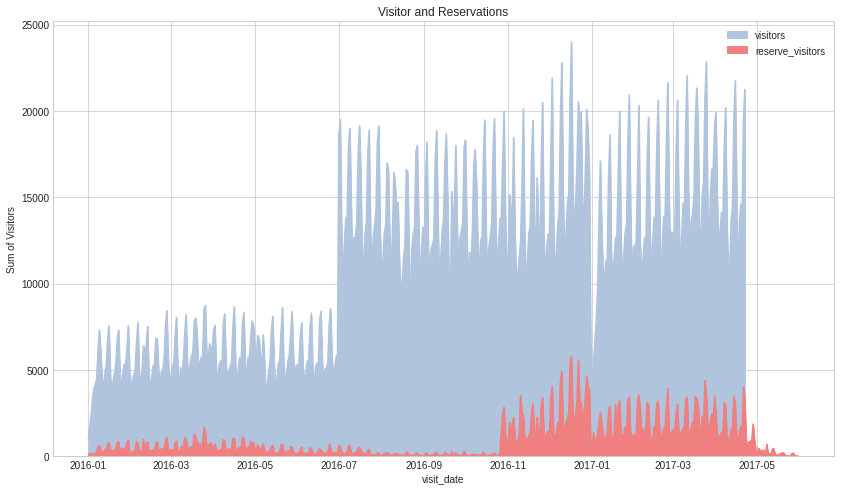

In [ ]:
import matplotlib.pyplot as plt

f,ax = plt.subplots(1,1,figsize=(14,8))
plt1 = air_visit_data.groupby(['visit_date'], as_index=False).agg({'visitors': np.sum})
plt2 = air.groupby(['visit_date'], as_index=False).agg({'reserve_visitors': np.sum})

plt1 = plt1.set_index('visit_date')
plt2 = plt2.set_index('visit_date')

plt1.plot(color='lightsteelblue', kind='area', ax=ax)
plt2.plot(color='lightcoral', kind='area', ax=ax)

plt.ylabel("Sum of Visitors")
plt.title("Visitor and Reservations")

---

* 시각화를 하기 위해 방문자 데이터와 가게 정보 데이터를 병합한 과정이다.

In [ ]:
new_air_visit = pd.merge(air_visit_data, air_store_info, on='air_store_id', how='inner')
display(new_air_visit.head(3), new_air_visit.shape, new_air_visit['air_store_id'].unique().shape)

air_store_id  visit_date  ...   latitude   longitude
0  air_ba937bf13d40fb24  2016-01-13  ...  35.658068  139.751599
1  air_ba937bf13d40fb24  2016-01-14  ...  35.658068  139.751599
2  air_ba937bf13d40fb24  2016-01-15  ...  35.658068  139.751599

[3 rows x 14 columns]

(252108, 14)

(829,)

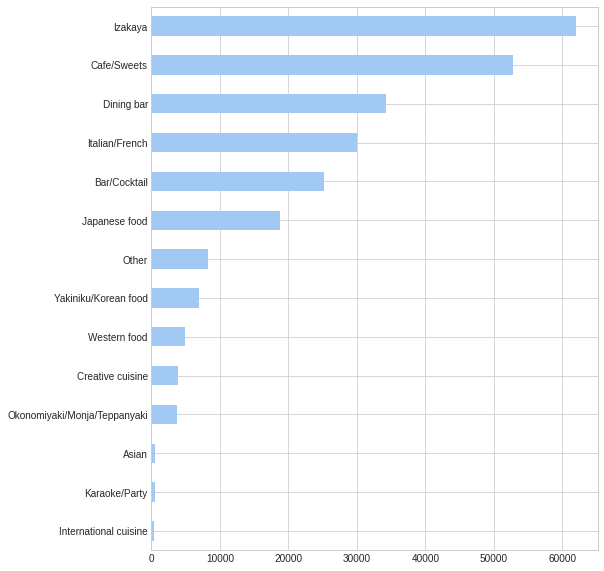

air_genre_name
Izakaya                         62052
Cafe/Sweets                     52764
Dining bar                      34192
Italian/French                  30011
Bar/Cocktail                    25135
Japanese food                   18789
Other                            8246
Yakiniku/Korean food             7025
Western food                     4897
Creative cuisine                 3868
Okonomiyaki/Monja/Teppanyaki     3706
Asian                             535
Karaoke/Party                     516
International cuisine             372
Name: air_store_id, dtype: int64


In [ ]:
new_air_visit.air_genre_name.value_counts().sort_values().plot(kind='barh')

fig = plt.gcf()
fig.set_size_inches(8, 10)
plt.show()
print(new_air_visit['air_store_id'].groupby(new_air_visit['air_genre_name']).count().sort_values(ascending=False))

> 시각화 된 데이터 해석

1. 확실히 이자카야 장르가 인기가 제일 많은 것을 확인할 수 있었다.

2. 그다음은 Cafe, Dining bar, Italian/French 순으로 인기가 많았다.

---

* 업종별 방문자 `boxplot`

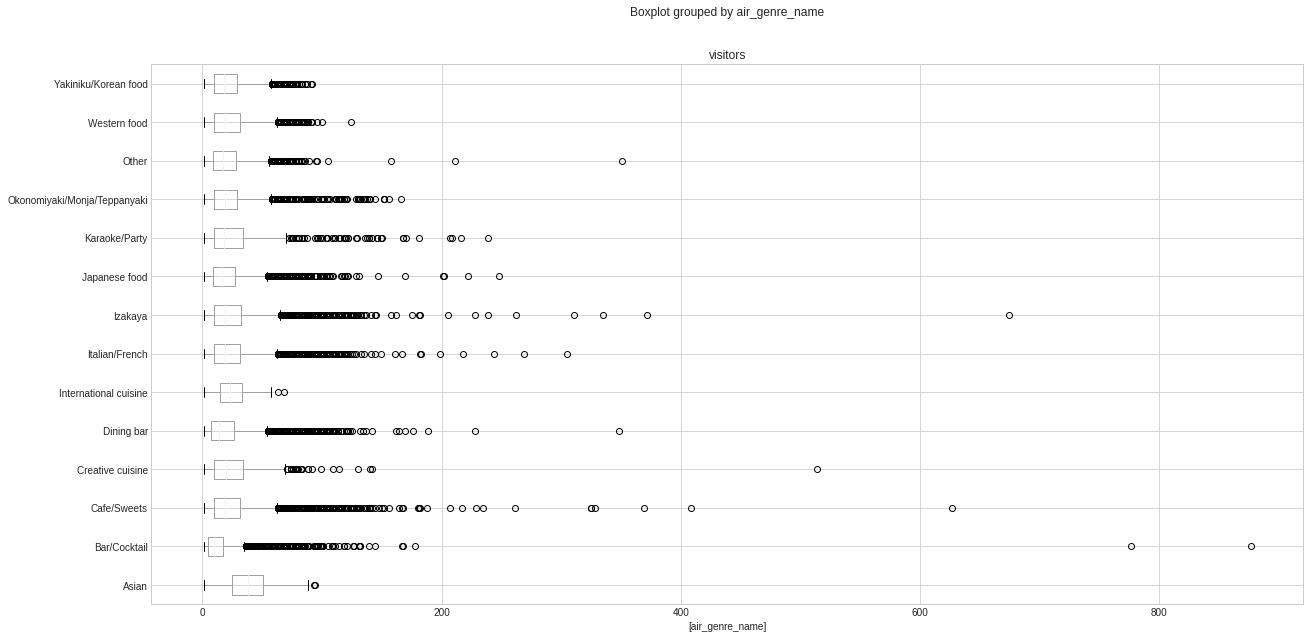

In [ ]:
plt.rcParams['figure.figsize']=(20,10)
boxplot=visit_store[['air_genre_name', 'visitors']].boxplot(by = 'air_genre_name',vert=False) # 축 변경 True 세로 => default
plt.show()

* boxplot을 통해 업종별로 이상치(?)를 관측할 수 있었다.

* 단체 회식이 있는 경우 방문자 수가 급증해서 이상치가 찍혀 나온 것으로 예상하고,<br> 가게의 특정 이벤트나 홍보가 맞물려서 갑작스럽게 방문자 수가 급증한 것으로도 예상할 수 있다.

* Bar/Cocktail의 경우는 위 `countplot`에서 4위를 기록했는데,<br>
방문자수가 800이 넘는 경우를 한번 보였다.

---

In [ ]:
area_split = visit_store['air_area_name'].str.split(" ")

visit_store["todobuken"] = area_split.str.get(0)

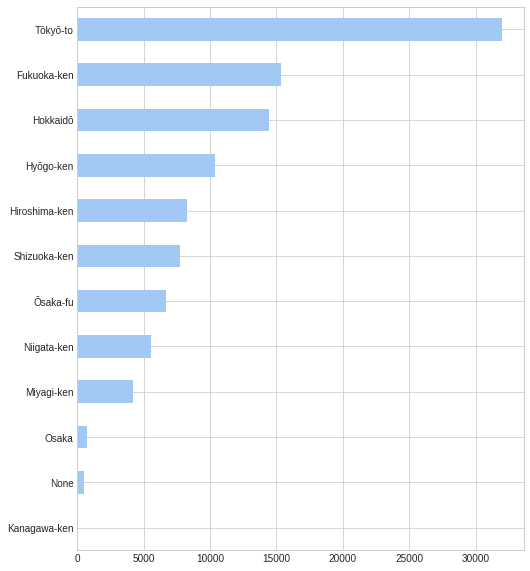

todobuken
Tōkyō-to         133063
Fukuoka-ken       39645
Ōsaka-fu          22821
Hyōgo-ken         17846
Hokkaidō          13055
Hiroshima-ken      9858
Miyagi-ken         5959
Shizuoka-ken       5798
Niigata-ken        4063
Name: air_store_id, dtype: int64


In [ ]:
air.todobuken.value_counts().sort_values().plot(kind='barh')
fig=plt.gcf()
fig.set_size_inches(8, 10)
fig.patch.set_facecolor('white')
plt.show()
print(visit_store['air_store_id'].groupby(visit_store['todobuken']).count().sort_values(ascending=False))

* 확실히 예약자 데이터를 활용했을 때랑 결과는 동일하였다.

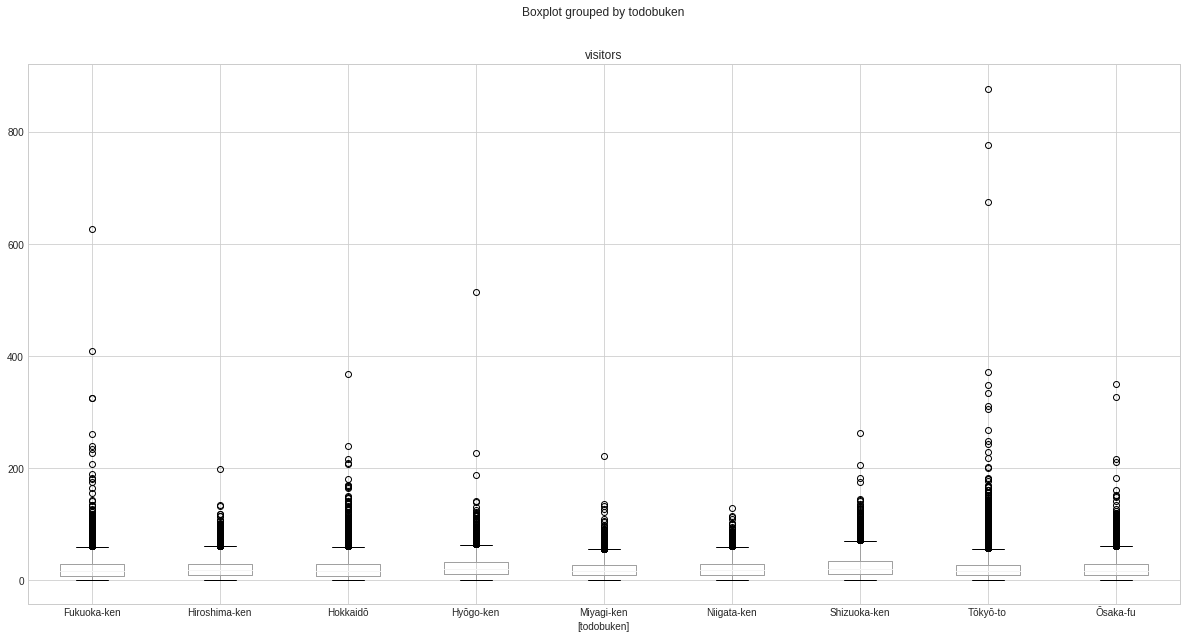

In [ ]:
visit_store[['todobuken', 'visitors']].boxplot(by = 'todobuken')

* 도쿄(일본의 수도)는 사람도 많이 방문했지만 특정한 날에 800명이 넘는 방문자 수를 보였다.

---

## 지도 데이터 그리기

In [ ]:
location = new_air_visit.groupby(['latitude', 'longitude']).size().reset_index()
locationheat = location[['latitude', 'longitude']]
locationheat = locationheat.values.tolist()

map1 = folium.Map(location=[39, 139],
                  tiles="Stamen Watercolor",
                  zoom_start=5)

heatmap = plugins.HeatMap(locationheat).add_to(map1)
map1

In [ ]:
location =new_air_visit.groupby(['air_store_id','air_genre_name'])['latitude','longitude'].mean().dropna(axis=0).reset_index(drop=False)
locationlist = location[['latitude', 'longitude']]
locationlist = locationlist.values.tolist()
map2 = folium.Map(location=[39, 139], 
                        tiles = "Stamen Toner",# width=1000, height=500,
                        zoom_start = 5)

marker_cluster=plugins.MarkerCluster().add_to(map2)
for point in range(0, len(location)):
    folium.Marker(locationlist[point], popup=location['air_genre_name'][point], 
    icon=folium.Icon(color='blue', icon_color='red', 
                     #icon='fa fa-info-circle',
                     icon='fa fa-circle-o-notch fa-spin',
                     angle=0, 
                     prefix='fa')).add_to(marker_cluster)
map2

# Train, Test 초기 테이블 생성

* Train 데이터는 위에서 시각화 과정동안 전처리를 했으므로 Test 데이터 또한 같은 변수르 추가한다.

In [ ]:
sample_submission.head(3)

id  visitors
0  air_00a91d42b08b08d9_2017-04-23         0
1  air_00a91d42b08b08d9_2017-04-24         0
2  air_00a91d42b08b08d9_2017-04-25         0

* `sample_submission` 테이블에 마찬가지로 `colomns` 추가하기
* `sample_submission` 의 `id`를 `visit_date`와 `air_store_id`로 나눠서 `column`으로 입력
* `sample_submission` 테이블이 `test set`의 base가 된다

In [ ]:
sample_submission['visit_date'] = sample_submission['id'].map(lambda x: str(x).split('_')[2]) #sample_submission의 id가 날짜랑 결합이 되어있다.
sample_submission['air_store_id'] = sample_submission['id'].map(lambda x: '_'.join(x.split('_')[:2]))
sample_submission['visit_date'] = pd.to_datetime(sample_submission['visit_date'])
sample_submission['day'] = sample_submission['visit_date'].dt.day
sample_submission['dow'] = sample_submission['visit_date'].dt.dayofweek
sample_submission['dow_name'] = sample_submission['visit_date'].dt.day_name()
sample_submission['year'] = sample_submission['visit_date'].dt.year
sample_submission['month'] = sample_submission['visit_date'].dt.month
sample_submission['week'] = sample_submission['visit_date'].dt.week
sample_submission['quarter'] = sample_submission['visit_date'].dt.quarter
sample_submission['visit_date'] = sample_submission['visit_date'].dt.date

In [ ]:
# sample_submission(test)의 unique store 가 어떤것들이 있는지 확인
unique_stores = sample_submission['air_store_id'].unique()

# 전체 stores중에 해당 unique_stores에 dow를 추가하는 것으로 생각 됨
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)
stores

air_store_id  dow
0     air_00a91d42b08b08d9    0
1     air_0164b9927d20bcc3    0
2     air_0241aa3964b7f861    0
3     air_0328696196e46f18    0
4     air_034a3d5b40d5b1b1    0
...                    ...  ...
5742  air_fea5dc9594450608    6
5743  air_fee8dcf4d619598e    6
5744  air_fef9ccb3ba0da2f7    6
5745  air_ffcc2d5087e1b476    6
5746  air_fff68b929994bfbd    6

[5747 rows x 2 columns]

* 위에서 만든 `stores`에 `training data(air_visit_data)`의 방문자에 대한 기본통계량을 추가하는 과정

In [ ]:
tmp = air_visit_data.groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

tmp = air_visit_data.groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])

tmp = air_visit_data.groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])

tmp = air_visit_data.groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])

tmp = air_visit_data.groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
stores

air_store_id  dow  ...  max_visitors  count_observations
0     air_00a91d42b08b08d9    0  ...          47.0                35.0
1     air_0164b9927d20bcc3    0  ...          19.0                20.0
2     air_0241aa3964b7f861    0  ...          23.0                63.0
3     air_0328696196e46f18    0  ...          27.0                12.0
4     air_034a3d5b40d5b1b1    0  ...          66.0                37.0
...                    ...  ...  ...           ...                 ...
5742  air_fea5dc9594450608    6  ...          35.0                41.0
5743  air_fee8dcf4d619598e    6  ...          43.0                40.0
5744  air_fef9ccb3ba0da2f7    6  ...          30.0                41.0
5745  air_ffcc2d5087e1b476    6  ...           9.0                 8.0
5746  air_fff68b929994bfbd    6  ...          10.0                30.0

[5747 rows x 7 columns]

* 범주형 데이터를 수치로 바꿔주는 `LabelEncoder`를 하였다.<br>
이후 사용할 모델이 범주형 데이터를 필요로 하지 않기 때문이다.

In [ ]:
# LabelEncoder = 문자 정보를 숫자로 대체 시켜준다 ex) ['apple','banana','orange] -> [0, 1, 2]
from sklearn.preprocessing import LabelEncoder

# stores 에 air_store_info의 정보를 추가 시켜준다
stores = pd.merge(stores, air_store_info, how='inner', on=['air_store_id']) 

# labelencoder를 생성
lbl = LabelEncoder()

# air_genre_name 과 air_area_name 을 각각 숫자로 바꿔줌
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

In [ ]:
stores.head(3)

air_store_id  dow  ...   latitude   longitude
0  air_00a91d42b08b08d9    0  ...  35.694003  139.753595
1  air_00a91d42b08b08d9    1  ...  35.694003  139.753595
2  air_00a91d42b08b08d9    2  ...  35.694003  139.753595

[3 rows x 11 columns]

In [ ]:
date_info.rename(columns={'calendar_date': 'visit_date'}, inplace=True)
date_info.head(3)

visit_date day_of_week  holiday_flg
0  2016-01-01      Friday            1
1  2016-01-02    Saturday            1
2  2016-01-03      Sunday            1

In [ ]:
# data_info 파일도 type 변경 및 label transforming 을 진행
date_info['visit_date'] = pd.to_datetime(date_info['visit_date'])
date_info['day_of_week'] = lbl.fit_transform(date_info['day_of_week'])
date_info['visit_date'] = date_info['visit_date'].dt.date 

In [ ]:
# train 과 test 에 사용하기 위해 하나씩 merge하는 작업을 진행한다.
# 먼저 date_info를 merge하고
train = pd.merge(air_visit_data, date_info, how='left', on=['visit_date']) 
test = pd.merge(sample_submission, date_info, how='left', on=['visit_date'])

In [ ]:
display(train.head(3), test.head(3))

air_store_id  visit_date  ...  day_of_week  holiday_flg
0  air_ba937bf13d40fb24  2016-01-13  ...            6            0
1  air_ba937bf13d40fb24  2016-01-14  ...            4            0
2  air_ba937bf13d40fb24  2016-01-15  ...            0            0

[3 rows x 12 columns]

id  visitors  ... day_of_week holiday_flg
0  air_00a91d42b08b08d9_2017-04-23         0  ...           3           0
1  air_00a91d42b08b08d9_2017-04-24         0  ...           1           0
2  air_00a91d42b08b08d9_2017-04-25         0  ...           5           0

[3 rows x 13 columns]

* 아까 기본통계량을 추가했던 DataFrame `stores`를 각각 train, test에 병합하였다.

In [ ]:
# 이어서 위에서 만들어 온 stores를 merge 해 준다
train = pd.merge(air_visit_data, stores, how='inner', on=['air_store_id','dow']) 
test = pd.merge(sample_submission, stores, how='inner', on=['air_store_id','dow'])

In [ ]:
display(train.head(3), train.shape, test.head(3), test.shape)

air_store_id  visit_date  ...   latitude   longitude
0  air_ba937bf13d40fb24  2016-01-13  ...  35.658068  139.751599
1  air_ba937bf13d40fb24  2016-01-20  ...  35.658068  139.751599
2  air_ba937bf13d40fb24  2016-01-27  ...  35.658068  139.751599

[3 rows x 19 columns]

(250468, 19)

id  visitors  ...   latitude   longitude
0  air_00a91d42b08b08d9_2017-04-23         0  ...  35.694003  139.753595
1  air_00a91d42b08b08d9_2017-04-30         0  ...  35.694003  139.753595
2  air_00a91d42b08b08d9_2017-05-07         0  ...  35.694003  139.753595

[3 rows x 20 columns]

(32019, 20)

# `merge`를 위한 `air_reserve` / `hpg_reserve`의 `visit_datetime` 변경

In [ ]:
display(air_reserve.head(3), hpg_reserve.head(3))

air_store_id  ... reserve_visitors
0  air_877f79706adbfb06  ...                1
1  air_db4b38ebe7a7ceff  ...                3
2  air_db4b38ebe7a7ceff  ...                6

[3 rows x 4 columns]

hpg_store_id  ... reserve_visitors
0  hpg_c63f6f42e088e50f  ...                1
1  hpg_dac72789163a3f47  ...                3
2  hpg_c8e24dcf51ca1eb5  ...                2

[3 rows x 4 columns]

In [ ]:
air_reserve['visit_date'] = pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['visit_date'] = air_reserve['visit_date'].dt.date

hpg_reserve['visit_date'] = pd.to_datetime(hpg_reserve['visit_datetime'])
hpg_reserve['visit_date'] = hpg_reserve['visit_date'].dt.date

In [ ]:
display(air_reserve.head(3), hpg_reserve.head(3))

air_store_id       visit_datetime  ... reserve_visitors  visit_date
0  air_877f79706adbfb06  2016-01-01 19:00:00  ...                1  2016-01-01
1  air_db4b38ebe7a7ceff  2016-01-01 19:00:00  ...                3  2016-01-01
2  air_db4b38ebe7a7ceff  2016-01-01 19:00:00  ...                6  2016-01-01

[3 rows x 5 columns]

hpg_store_id       visit_datetime  ... reserve_visitors  visit_date
0  hpg_c63f6f42e088e50f  2016-01-01 11:00:00  ...                1  2016-01-01
1  hpg_dac72789163a3f47  2016-01-01 13:00:00  ...                3  2016-01-01
2  hpg_c8e24dcf51ca1eb5  2016-01-01 16:00:00  ...                2  2016-01-01

[3 rows x 5 columns]

In [ ]:
# hpg는 air_store_id 도 필요하기 때문에 hpg_store_id 에 해당하는 air_store_id 를 추가 해 준다
store_id_relation.head(3)

air_store_id          hpg_store_id
0  air_63b13c56b7201bd9  hpg_4bc649e72e2a239a
1  air_a24bf50c3e90d583  hpg_c34b496d0305a809
2  air_c7f78b4f3cba33ff  hpg_cd8ae0d9bbd58ff9

In [ ]:
hpg_reserve = pd.merge(hpg_reserve, store_id_relation, how='inner', on=['hpg_store_id'])

In [ ]:
hpg_reserve.head(3)

hpg_store_id       visit_datetime  ...  visit_date          air_store_id
0  hpg_878cc70b1abc76f7  2016-01-01 19:00:00  ...  2016-01-01  air_db80363d35f10926
1  hpg_878cc70b1abc76f7  2016-01-02 19:00:00  ...  2016-01-02  air_db80363d35f10926
2  hpg_878cc70b1abc76f7  2016-01-03 18:00:00  ...  2016-01-03  air_db80363d35f10926

[3 rows x 6 columns]

In [ ]:
 # air_reserve, hpg_reserve 의 값에서 air_sotre_id 와 visite_date가 일치하는 값들을 가져와 merge
train = pd.merge(train, air_reserve, how='left', on=['air_store_id','visit_date']) 
train = pd.merge(train, hpg_reserve, how='left', on=['air_store_id','visit_date'])
test = pd.merge(test, air_reserve, how='left', on=['air_store_id','visit_date'])
test = pd.merge(test, hpg_reserve, how='left', on=['air_store_id','visit_date'])

In [ ]:
display(train.head(3), test.head(3))

air_store_id  visit_date  ...  reserve_datetime_y  reserve_visitors_y
0  air_ba937bf13d40fb24  2016-01-13  ...                 NaN                 NaN
1  air_ba937bf13d40fb24  2016-01-20  ...                 NaN                 NaN
2  air_ba937bf13d40fb24  2016-01-27  ...                 NaN                 NaN

[3 rows x 26 columns]

id  ...  reserve_visitors_y
0  air_00a91d42b08b08d9_2017-04-23  ...                 NaN
1  air_00a91d42b08b08d9_2017-04-30  ...                 NaN
2  air_00a91d42b08b08d9_2017-05-07  ...                 NaN

[3 rows x 27 columns]

In [ ]:
print(train.columns)

Index(['air_store_id', 'visit_date', 'visitors', 'day', 'dow', 'dow_name',
       'year', 'month', 'week', 'quarter', 'min_visitors', 'mean_visitors',
       'median_visitors', 'max_visitors', 'count_observations',
       'air_genre_name', 'air_area_name', 'latitude', 'longitude',
       'visit_datetime_x', 'reserve_datetime_x', 'reserve_visitors_x',
       'hpg_store_id', 'visit_datetime_y', 'reserve_datetime_y',
       'reserve_visitors_y'],
      dtype='object')


In [ ]:
print(test.columns)

Index(['id', 'visitors', 'visit_date', 'air_store_id', 'day', 'dow',
       'dow_name', 'year', 'month', 'week', 'quarter', 'min_visitors',
       'mean_visitors', 'median_visitors', 'max_visitors',
       'count_observations', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude', 'visit_datetime_x', 'reserve_datetime_x',
       'reserve_visitors_x', 'hpg_store_id', 'visit_datetime_y',
       'reserve_datetime_y', 'reserve_visitors_y'],
      dtype='object')


In [ ]:
train_x = train.drop(['air_store_id', 'visit_date', 'visitors', 'air_area_name', 'air_genre_name', 'latitude'	,'longitude',
                      'visit_datetime_x',	'reserve_datetime_x' ,'reserve_visitors_x' ,'visit_datetime_y'	,'reserve_datetime_y',	
                      'reserve_visitors_y'	,'visit_datetime_x'	,'reserve_datetime_x'	,'reserve_visitors_x'	,'hpg_store_id'	,
                      'visit_datetime_y'	,'reserve_datetime_y'	,'reserve_visitors_y', 'dow_name'], axis=1)
train_y = np.log1p(train['visitors'].values)

print(train_x.shape, train_y.shape)
test_x = test.drop(['id', 'air_store_id', 'visit_date', 'visitors', 'air_area_name', 'air_genre_name', 'latitude'	,'longitude',
                    'visit_datetime_x'	,'reserve_datetime_x'	,'reserve_visitors_x'	,'hpg_store_id'	,'visit_datetime_y'	,'reserve_datetime_y',	
                    'reserve_visitors_y', 'dow_name'], axis=1)

(337310, 11) (337310,)


In [ ]:
display(train_x.head(3), test_x.head(3))

day  dow  year  ...  median_visitors  max_visitors  count_observations
0   13    2  2016  ...             25.0          57.0                64.0
1   20    2  2016  ...             25.0          57.0                64.0
2   27    2  2016  ...             25.0          57.0                64.0

[3 rows x 11 columns]

day  dow  year  ...  median_visitors  max_visitors  count_observations
0   23    6  2017  ...              2.0           2.0                 1.0
1   30    6  2017  ...              2.0           2.0                 1.0
2    7    6  2017  ...              2.0           2.0                 1.0

[3 rows x 11 columns]

In [ ]:
print('train_x shape is:', train_x.shape)
print('test_x shape is:', test_x.shape)

train_x shape is: (337310, 11)
test_x shape is: (32873, 11)


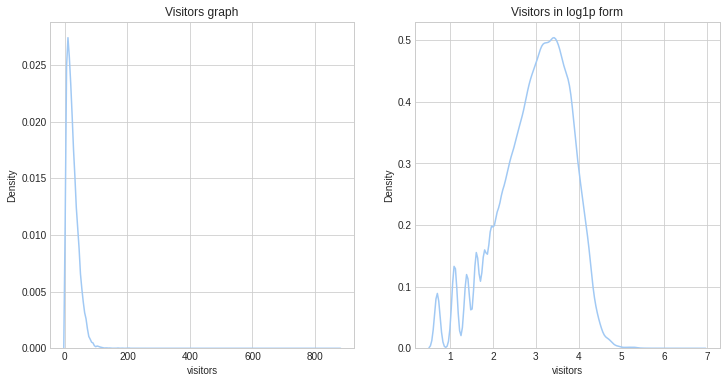

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.kdeplot(train['visitors'], ax=ax[0])
ax[0].set_title('Visitors graph')
sns.kdeplot(np.log1p(train['visitors']), ax=ax[1]) # 정규화 진행
ax[1].set_title('Visitors in log1p form');

# Lightgbm

In [ ]:
import lightgbm as lgb

lgb = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=60,
    learning_rate=0.01,
    n_estimators=10000)

lgb.fit(train_x, train_y, eval_metric='rmse') # train_y = np.log1p(train['visitors'].values)
predict_y = lgb.predict(test_x) # test_x 값으로 prediction 실행

In [ ]:
test['visitors'] = np.expm1(predict_y) # no.log1p 로 변화시켰던 값을 np.expm1을 이용해 다시 원래대로 돌려주는 작업
test[['id', 'visitors']].to_csv('lgb_submission.csv', index=False, float_format='%.3f')  # csv로 출력

In [ ]:
df = pd.read_csv('lgb_submission.csv')
df

id  visitors
0      air_00a91d42b08b08d9_2017-04-23     2.181
1      air_00a91d42b08b08d9_2017-04-30     2.006
2      air_00a91d42b08b08d9_2017-05-07     2.048
3      air_00a91d42b08b08d9_2017-05-14     2.302
4      air_00a91d42b08b08d9_2017-05-21     1.874
...                                ...       ...
32868  air_fff68b929994bfbd_2017-04-29     7.115
32869  air_fff68b929994bfbd_2017-05-06     6.104
32870  air_fff68b929994bfbd_2017-05-13     6.889
32871  air_fff68b929994bfbd_2017-05-20     6.631
32872  air_fff68b929994bfbd_2017-05-27     7.007

[32873 rows x 2 columns]

### 다른 노트북으로 한 결과 (첨부파일 제출할 예정)

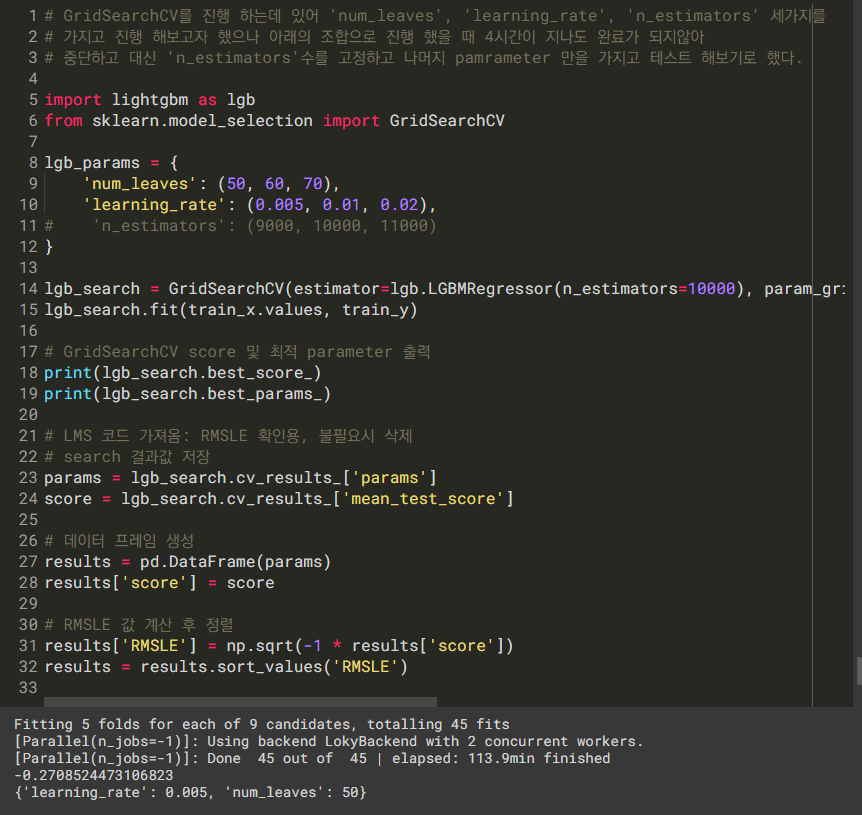

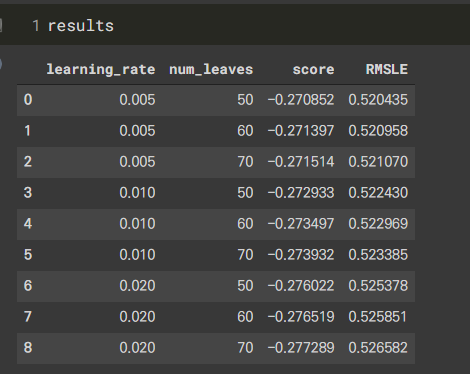

## 결과 CSV 파일 저장

In [ ]:
new_df = df.copy()

df

id  visitors
0      air_00a91d42b08b08d9_2017-04-23     2.181
1      air_00a91d42b08b08d9_2017-04-30     2.006
2      air_00a91d42b08b08d9_2017-05-07     2.048
3      air_00a91d42b08b08d9_2017-05-14     2.302
4      air_00a91d42b08b08d9_2017-05-21     1.874
...                                ...       ...
32868  air_fff68b929994bfbd_2017-04-29     7.115
32869  air_fff68b929994bfbd_2017-05-06     6.104
32870  air_fff68b929994bfbd_2017-05-13     6.889
32871  air_fff68b929994bfbd_2017-05-20     6.631
32872  air_fff68b929994bfbd_2017-05-27     7.007

[32873 rows x 2 columns]

In [ ]:
df = df.drop_duplicates(['id'], keep = 'first')

In [ ]:
df[['id', 'visitors']].to_csv('new_lgb_submission.csv', index=False, float_format='%.3f')  # csv로 출력

# xgboost

In [ ]:
# XGB 의 경우 속도가 많이 느리기 때문에 정해진 parameter로 1회 실행하는데에도 약 1시간이 소요 되었다.
# GridSearchCV를 진행할 경우 1회당 최소 두시간 이상씩 걸릴 것으로 예상 되며, 지금의 상황에서는
# 시간적으로 상당히 비효율적이라 생각되어 따로 진행하지 않고 다른사람의 코드를 참고하여 설정하였다. 
# 참조: https://www.kaggle.com/festa78/simple-xgboost-lb-0-495
import xgboost as xgb

boost_params = {'eval_metric': 'rmse'}
xgb = xgb.XGBRegressor(
    max_depth=8,
    learning_rate=0.01,
    n_estimators=10000,
    objective='reg:linear',
    gamma=0,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=1,
    scale_pos_weight=1,
    seed=27,
    **boost_params)

xgb.fit(train_x, train_y)
predict_y = xgb.predict(test_x)

[16:38:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
test['visitors'] = np.expm1(predict_y) # np.log1p 로 변화시켰던 값을 np.expm1을 이용해 다시 원래대로 돌려주는 작업
test[['id', 'visitors']].to_csv('xgb_submission.csv', index=False, float_format='%.3f') # csv 출력

## 결과 CSV 파일 저장

In [ ]:
df2 = pd.read_csv('xgb_submission.csv')
df2

id  visitors
0      air_00a91d42b08b08d9_2017-04-23     1.810
1      air_00a91d42b08b08d9_2017-04-30     0.943
2      air_00a91d42b08b08d9_2017-05-07     2.048
3      air_00a91d42b08b08d9_2017-05-14     2.254
4      air_00a91d42b08b08d9_2017-05-21     1.905
...                                ...       ...
32868  air_fff68b929994bfbd_2017-04-29     5.958
32869  air_fff68b929994bfbd_2017-05-06     4.216
32870  air_fff68b929994bfbd_2017-05-13     6.071
32871  air_fff68b929994bfbd_2017-05-20     5.781
32872  air_fff68b929994bfbd_2017-05-27     5.865

[32873 rows x 2 columns]

In [ ]:
df2 = df2.drop_duplicates(['id'], keep = 'first')

In [ ]:
df2[['id', 'visitors']].to_csv('xgb_submission.csv', index=False, float_format='%.3f')  # csv로 출력

# 참고했던 자료

[국가통계포탈(Kosis)-GDP성장률](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAA905&vw_cd=&list_id=&scrId=&seqNo=&lang_mode=ko&obj_var_id=&itm_id=&conn_path=E1&docId=0079431922&markType=S&itmNm=%EC%9D%BC%EB%B3%B8)<br>
[지도그래프-캐글 커널](https://www.kaggle.com/faizalabdkadir/recruit-visual-eda-itadakimasu)<br>
[Restaurant Visitor Forecasting EDA with R - 한글번역](https://www.kaggle.com/maestroyi/restaurant-visitor-forecasting-eda-with-r)<br>
[Suprise Me 2! - 캐글 커널](https://www.kaggle.com/tunguz/surprise-me-2) <br>
[문자열 인덱싱 및 파싱](http://hleecaster.com/pandas-data-cleaning-2/)<br>
[matplotlib을 통한 boxplot그리기](https://continuous-development.tistory.com/147) <br>
[Matplotlib 기본 사용](https://wikidocs.net/92071)<BR>
[lightgbm - 커널](https://www.kaggle.com/festa78/simple-lightgbm-lb-0-493)<br>
[xgboost - 커널](https://www.kaggle.com/festa78/simple-xgboost-lb-0-495)

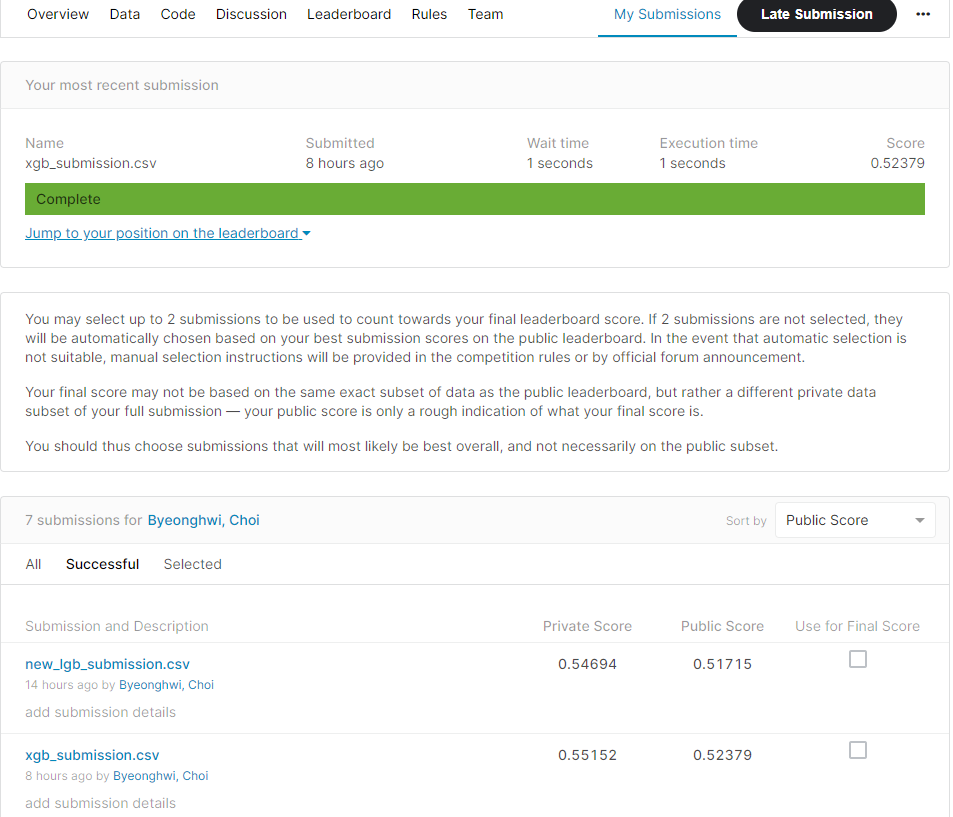

* lgb의 성능이 조금 더 좋았다.